In [ ]:
%pip install -U gym[atari,accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 8.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 16.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.2 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827694 sha256=0bf1dbb51741a6f4ad58dda87901de351c781c77d7335e4d0938e4f7d5045d19
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446667 sha256=9d2009059574401f31794fdd5db9a91db32cb2f2b4b5a0a94502c1e22232c90a
  Stored in directory: /root/.cache/pip/whee

In [ ]:
import torch
import torch.optim as optim
import random
import torch
import torch.nn as nn
import numpy as np
from collections import deque
import gym
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(7 * 7 * 64, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def act(self, state, epsilon, device=device):
        if random.random() > epsilon:
            state = torch.FloatTensor(np.float32(state)).unsqueeze(0).to(device)
            q_value = self.forward(state)
            action = q_value.max(1)[1].item()
        else:
            action = random.randrange(self.num_actions)
        return action

cv2.ocl.setUseOpenCL(False)

def make_atari_env(env_id, episodic_life=True, clip_rewards=True, stack_frames=True, scale=False):
    env = gym.make(env_id, render_mode='rgb_array')
    if episodic_life:
        env = EpisodicLifeEnv(env)
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)

    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)

    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if stack_frames:
        env = FrameStack(env, 4)

    env = ImageToPyTorch(env)
    return env

class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        super().__init__(env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = np.random.randint(1, self.noop_max + 1)

        for _ in range(noops):
            obs, reward, terminated, truncated, info = self.env.step(self.noop_action)
            if terminated or truncated:
                obs, info = self.env.reset(**kwargs)
        return obs, info

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        obs, reward, terminated, truncated, info = self.env.step(1)
        if terminated or truncated:
            obs, info = self.env.reset(**kwargs)
        obs, reward, terminated, truncated, info = self.env.step(2)
        if terminated or truncated:
            obs, info = self.env.reset(**kwargs)
        return obs, info

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.was_real_done = terminated or truncated
        lives = self.env.unwrapped.ale.lives()

        if lives < self.lives and lives > 0:
            terminated = True
        self.lives = lives
        return obs, reward, terminated, truncated, info

    def reset(self, **kwargs):
        if self.was_real_done:
            obs, info = self.env.reset(**kwargs)
        else:
            obs, reward, terminated, truncated, info = self.env.step(0)
            info = {}
        self.lives = self.env.unwrapped.ale.lives()
        return obs, info

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        super().__init__(env)
        self._obs_buffer = np.zeros((2,) + env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        terminated = truncated = False
        info = {}

        for i in range(self._skip):
            obs, reward, terminated, truncated, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if terminated or truncated:
                break

        max_frame = self._obs_buffer.max(axis=0)
        return max_frame, total_reward, terminated, truncated, info

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)

    def reward(self, reward):
        return np.sign(reward)

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.width = 84
        self.height = 84
        self.observation_space = gym.spaces.Box(low=0, high=255,
                                             shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        super().__init__(env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255,
                                             shape=(shp[0], shp[1], shp[2] * k), dtype=np.uint8)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        for _ in range(self.k):
            self.frames.append(obs)
        return self._get_ob(), info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.frames.append(obs)
        return self._get_ob(), reward, terminated, truncated, info

    def _get_ob(self):
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)

    def observation(self, observation):
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames:
    def __init__(self, frames):
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=2)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        old_shape = env.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0,
            shape=(old_shape[-1], old_shape[0], old_shape[1]),
            dtype=np.uint8
        )

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return (np.concatenate(states),
                np.array(actions),
                np.array(rewards, dtype=np.float32),
                np.concatenate(next_states),
                np.array(dones, dtype=np.uint8))

    def __len__(self):
        return len(self.buffer)

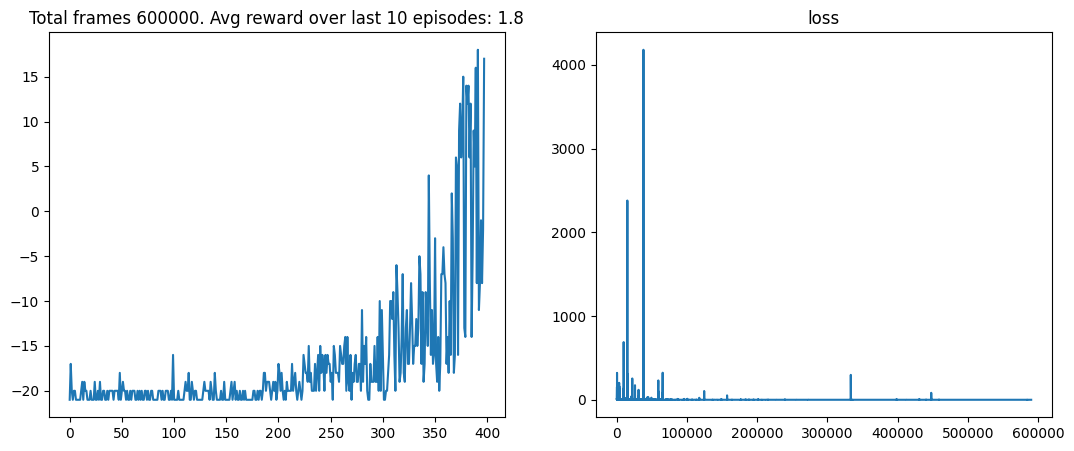

Eval cumulative reward: 3.0 , Eval loss: 0.005507411900907755
Episode: 398 has ended
Eval cumulative reward: 11.0 , Eval loss: 0.007649644743651152
Episode: 399 has ended
Saving weights for 400 and rendering demo


/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /content folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Episode 1 | Reward: 18.0
Moviepy - Building video /content/dqn_pong-episode-1.mp4.
Moviepy - Writing video /content/dqn_pong-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/dqn_pong-episode-1.mp4
Episode 2 | Reward: 18.0
Moviepy - Building video /content/dqn_pong-episode-2.mp4.
Moviepy - Writing video /content/dqn_pong-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /content/dqn_pong-episode-2.mp4
Episode 3 | Reward: 1.0


In [ ]:

import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# Hyperparameters
EPISODES = 400
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.01
EPS_DECAY = 30000

INITIAL_MEMORY = 10000
MEMORY_SIZE = 10 * INITIAL_MEMORY

MODEL_SAVE_PATH = '.'
VIDEO_SAVE_PATH = '.'


def plot_stats(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f'Total frames {frame_idx}. Avg reward over last 10 episodes: {np.mean(rewards[-10:])}')
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()


def compute_loss(model, replay_buffer, batch_size, gamma, device=device):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state = torch.FloatTensor(np.float32(state)).to(device)
    next_state = torch.FloatTensor(np.float32(next_state)).to(device)
    action = torch.LongTensor(action).to(device)
    reward = torch.FloatTensor(reward).to(device)
    done = torch.FloatTensor(done).to(device)

    q_values_old = model(state)
    q_values_new = model(next_state)

    q_value_old = q_values_old.gather(1, action.unsqueeze(1)).squeeze(1)
    q_value_new = q_values_new.max(1)[0]
    expected_q_value = reward + gamma * q_value_new * (1 - done)

    loss = (q_value_old - expected_q_value.data).pow(2).mean()

    return loss

env_id = "PongNoFrameskip-v4"
env = make_atari_env(env_id)

model = DQN(env.observation_space.shape, env.action_space.n).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
replay_buffer = ReplayBuffer(MEMORY_SIZE)

steps_done = 0
episode_rewards = []
losses = []
model.train()
for episode in range(EPISODES):
    state, _ = env.reset()
    episode_reward = 0.0
    while True:
        epsilon = EPS_END + (EPS_START - EPS_END) * np.exp(- steps_done / EPS_DECAY)
        action = model.act(state, epsilon, device)
        steps_done += 1

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_buffer.push(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward

        if len(replay_buffer) > INITIAL_MEMORY:
            loss = compute_loss(model, replay_buffer, BATCH_SIZE, GAMMA, device)

            # Optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        if steps_done % 10000 == 0:
            plot_stats(steps_done, episode_rewards, losses)

        if done:
            episode_rewards.append(episode_reward)
            break

    if len(replay_buffer) > INITIAL_MEMORY:
      print("Eval cumulative reward: " + str(episode_reward), ", Eval loss: " + str(losses[-1]))
    print("Episode: " + str(episode) + " has ended")
    if (episode+1) % 100 == 0:
        path = os.path.join(MODEL_SAVE_PATH, f"{env.spec.id}_episode_{episode+1}.pth")
        print(f"Saving weights for {episode+1} and rendering demo")
        torch.save(model.state_dict(), path)

env.close()

from gym.wrappers import RecordVideo
env = RecordVideo(
    env,
    video_folder=VIDEO_SAVE_PATH,
    name_prefix="dqn_pong",
    episode_trigger=lambda x: x%20
)

# Evaluation loop
model.eval()
for episode in range(3):
    state, _ = env.reset()  # Correct unpacking for Gym 0.26+
    episode_reward = 0.0

    while True:
        action = model.act(state, epsilon=0, device=device)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        episode_reward += reward
        state = next_state

        if done:
            print(f"Episode {episode+1} | Reward: {episode_reward:.1f}")
            break